## Montando o Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir('drive/Shareddrives/monografia/monografia/teste_code')

## Lendo o Dataset

In [2]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup, SoupStrainer

In [3]:
df = pd.read_csv('scielo_dataset.csv', dtype={'ano':np.uint16})

In [4]:
topicos = ['produtos e materiais didáticos', 'pesquisa em ensino de física', 'história da física e ciências afins',
           'desenvolvimento em ensino de física', 'seção especial: informática no ensino de física', 'história da física',
           'história da física e áreas afins', 'seção especial: encontro " reflexões no ensino de física", sbf/mec ( brasília, 2005)']

In [5]:
edu_df = df.loc[(df['tipo'].isin(topicos)) & (df['ano'] > 2014)]  # Analisando de 2015 até 2022
del df

In [6]:
edu_df

,title,tipo,ano,doi_id,file_bruto_name
50,A gamificação como design instrucional,pesquisa em ensino de física,2022,10.1590/1806-9126-RBEF-2021-0362,0050.html
51,Ensino de física em tempos de pandemia: Instru...,pesquisa em ensino de física,2022,10.1590/1806-9126-RBEF-2021-0329,0051.html
52,O Ensino de Física à luz dos livros didáticos ...,pesquisa em ensino de física,2022,10.1590/1806-9126-RBEF-2021-0287,0052.html
53,Motivação e eficiência em estratégias de ensin...,pesquisa em ensino de física,2022,10.1590/1806-9126-RBEF-2021-0278,0053.html
54,Da Lei de Titius-Bode ao embate entre a Matéri...,pesquisa em ensino de física,2022,10.1590/1806-9126-RBEF-2021-0382,0054.html
...,...,...,...,...,...
784,Panorama geral da obra astronômica de Kepler,história da física e ciências afins,2015,10.1590/S1806-11173731794,0784.html
785,Jorge André Swieca: Uma figura ímpar na física...,história da física e ciências afins,2015,10.1590/S1806-11173731932,0785.html
806,História da ciência na sala de aula: Uma sequê...,desenvolvimento em ensino de física,2015,10.1590/S1806-11173741919,0806.html
807,Introduzindo problemas e curvas de perseguição...,desenvolvimento em ensino de física,2015,10.1590/S1806-11173741987,0807.html


In [7]:
arquivos = arquivos = edu_df['file_bruto_name'].values  # pegando os arquivos

In [8]:
def limpa_html(text_html) -> str:
     soup = BeautifulSoup(text_html, 'lxml', parse_only=SoupStrainer('div', attrs={'data-anchor': 'Text'}))

     # tags do título, citações, referências, equações e figuras foram removidas.
     remover = soup.find_all('h1') + soup.find_all('span', attrs={'class': 'ref'}) + \
               soup.find_all('div', attrs={'class':'row formula'}) + soup.find_all('div', attrs={'class': 'row fig'}) + \
               soup.find_all('math')

     for tag in remover:
          tag.decompose()

     return ' '.join(soup.text.lower().split())

In [9]:
textos = []
for arq in tqdm(arquivos):
     path = os.path.abspath(os.path.join('artigos_brutos', arq))

     with open(path, 'r', encoding='utf8') as f:
          text = f.read()

     textos.append(limpa_html(text))

100%|██████████| 323/323 [00:23<00:00, 13.72it/s]


## Download pacotes adicionais

In [10]:
from IPython.display import clear_output

In [11]:
# Download pacote adicional
import nltk
nltk.download('stopwords')
!python -m spacy download pt_core_news_lg
!python -m spacy download pt_core_news_md
!python -m spacy download pt_core_news_sm

clear_output()

## Análise NLP

In [12]:
import spacy
nlp = spacy.load("pt_core_news_lg")

from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

In [13]:
my = {'p', 'fig', 'p.', 'cm', 'et', 'al', 't', 's', 'm', 'v', 'd', 'of', 'the',
      'eq', 'figura', 'b', 'pi', 'ref', 'km', 'kg', 'ii', 'iii', 'iv', 'xix', 'mm',
      'δ', 'in', 'and', 'x', 'f', 'r', 'u', 'i', 'g', 'h', 'l', 'y', 'z', 'w', 'k', 'q'}
stop = set(stopwords.words('portuguese')).union(STOP_WORDS).union(my)

In [14]:
# tokenização e lemma
documentos = []
for texto in tqdm(textos):
     doc = nlp(texto)
     documentos.append([token.lemma_ for token in doc if token.lemma_ not in stop and token.is_alpha])

100%|██████████| 323/323 [03:43<00:00,  1.44it/s]


## Treinando o modelo gensim

In [43]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# Adiciona bigrams e trigrams para os documentos (só se aparecer 5 vezes ou mais).
bigram = Phrases(documentos, min_count=5)
for idx in range(len(documentos)):
     for token in bigram[documentos[idx]]:
          if '_' in token:  # se for um n-gram, adiciona no documento
               documentos[idx].append(token)

# cria o dicionário
dictionary = Dictionary(documentos)

# Filtra as palavras que ocorrem em menos de 30 documentos ou mais que 50% dos documentos.
dictionary.filter_extremes(no_below=30, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documentos]

# Train LDA model.
chunksize = 400
passes = 50
iterations = 400
eval_every = None  # Não calculo a perplexity, demora muito.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [27]:
medias_umass = {}
for n in tqdm(range(2,26)):
     model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=n,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )
     
     cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
     
     medias_umass[n] = cm_u_mass.get_coherence()

100%|██████████| 24/24 [11:48<00:00, 29.53s/it]


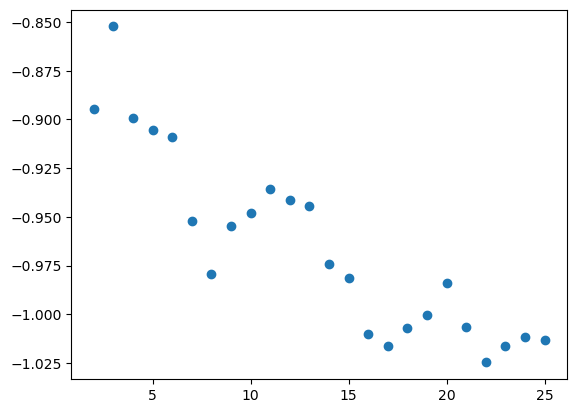

In [28]:
import matplotlib.pyplot as plt
plt.scatter(medias_umass.keys(), medias_umass.values())
plt.show()

### Rodando os melhores modelos

In [19]:
def printar_topicos(topics):
    for i, topic in enumerate(topics, start=1):
        print(f'Tópico {i} ({topic[1]:.4f}):')
        print('     ', end= '')
        for j, t in enumerate(topic[0], start=1):
            print(f'{t[1]} ({t[0]:.4f})', end = ' ')
            if j % 5 == 0:
                print('\n     ', end='')
        print()

#### Número de tópicos = 3

In [29]:
model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=3,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )

cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
print('Coerência média:', cm_u_mass.get_coherence())

topics = model.top_topics(corpus)
printar_topicos(topics)

Coerência média: -0.8522365230324019
Tópico 1 (-0.7206):
     aprendizagem (0.0110) disciplina (0.0087) item (0.0075) teste (0.0058) ensino_médio (0.0058) 
     avaliação (0.0058) turma (0.0057) conceitual (0.0056) metodologia (0.0055) educação (0.0053) 
     escola (0.0048) etapa (0.0046) prova (0.0042) questionário (0.0042) leitura (0.0041) 
     avaliar (0.0037) quadro (0.0037) desempenho (0.0036) estratégia (0.0035) público (0.0035) 
     
Tópico 2 (-0.8505):
     partícula (0.0107) sol (0.0100) corpo (0.0090) raio (0.0079) quântico (0.0073) 
     planeta (0.0067) terra (0.0065) estrela (0.0065) lente (0.0052) massa (0.0045) 
     século (0.0044) onda (0.0044) obra (0.0043) solar (0.0043) ângulo (0.0043) 
     matéria (0.0043) visão (0.0042) histórico (0.0040) plano (0.0038) época (0.0038) 
     
Tópico 3 (-0.9856):
     elétrico (0.0119) onda (0.0108) frequência (0.0078) magnético (0.0078) temperatura (0.0078) 
     tensão (0.0068) circuito (0.0067) massa (0.0065) comprimento (0.0

#### Número de tópicos = 11

In [48]:
model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=11,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )

cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
print('Coerência média:', cm_u_mass.get_coherence())

topics = model.top_topics(corpus)
printar_topicos(topics)

Coerência média: -0.9266430136058936
Tópico 1 (-0.7174):
     corpo (0.0249) obra (0.0095) visão (0.0078) século (0.0068) Newton (0.0067) 
     fluido (0.0063) matéria (0.0060) parecer (0.0060) histórico (0.0056) natural (0.0056) 
     concepção (0.0054) massa (0.0051) história (0.0048) afirmar (0.0048) pressão (0.0047) 
     calor (0.0047) publicar (0.0043) hipótese (0.0043) Ciência (0.0043) mecânica (0.0043) 
     
Tópico 2 (-0.7382):
     turma (0.0154) aprendizagem (0.0151) metodologia (0.0143) resolução_problema (0.0135) disciplina (0.0124) 
     conceitual (0.0097) atividade_experimental (0.0095) resolução (0.0085) avaliação (0.0083) teste (0.0079) 
     avaliar (0.0070) abrir (0.0069) tarefa (0.0065) resolver_problema (0.0060) motivação (0.0059) 
     ensino_médio (0.0058) ativo (0.0058) etapa (0.0057) tradicional (0.0057) habilidade (0.0055) 
     
Tópico 3 (-0.8253):
     sol (0.0421) estrela (0.0293) planeta (0.0287) terra (0.0274) solar (0.0191) 
     astronomia (0.0159) lua

In [51]:
a = model.alpha

In [52]:
e = model.eta
len(e)

1905

In [53]:
%%timeit
LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha=a,
          eta=e,
          iterations=iterations,
          num_topics=11,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )

33.6 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit
LdaMulticore(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha=a,
          eta=e,
          iterations=iterations,
          num_topics=11,
          passes=passes,
          eval_every=eval_every,
          random_state=99,
          workers=11
     )

52.6 s ± 525 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
